In [1]:
import torch
import torch.nn as nn
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import gc
gc.collect()
torch.cuda.empty_cache()
cuda = torch.device('cuda') 
print(torch.__version__)
print(torchvision.__version__)
print(torch.__version__)

1.10.0+cu113
0.11.1+cu113
1.10.0+cu113


In [2]:
#load the original mobilenetv2 weights for transfer learning
originalMobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/plupiman/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
#remove all but the classification layer as we have different classes and a different number of them
mobilenetLayers = [module for module in originalMobilenet.children()]
initialLayers = nn.Sequential(*mobilenetLayers[0:-1])

In [4]:
class newMobilenet(nn.Module):
    #outputclasses is the number of output labels the model needs to have 
    #initial layers is the layers of mobilenet
    def __init__(self, outputClasses, initialLayers):
        super(newMobilenet,self).__init__()
        self.initialLayers = initialLayers
        self.finalLayer = nn.Linear(1280   , outputClasses)
        self.softmax = nn.Softmax(1)
        self.pool = nn.AvgPool2d(7, stride = 1)
        
    def forward(self, x):
        x = self.initialLayers(x)
        x = self.pool(x)
        x = x.flatten(1)
        x = self.finalLayer(x)
        x = self.softmax(x)
        return x
    

In [5]:
#Trains the model with a particular optimizer, error function, set of image transformations, and a directory of images to train from
def train(model, optimizer, error, TRANSFORM_IMG, trainDir):
    EPOCHS = 10
    model.train()
    train = datasets.ImageFolder(trainDir, transform =TRANSFORM_IMG )
    batchSize = 32
    train = DataLoader(train, batch_size=batchSize, shuffle = True)
    #used to log the loss per each image, our metric for observing if augmentations have an effect on generalization
    lossPerImage = []
    #Iterates for each epoch
    for epoch in range(EPOCHS):
        epochLoss = 0
        images = 0
        #For every batch in training
        for idx, (xBatch, yBatch) in enumerate(train):
            xBatch = xBatch.view(-1, 3, 224, 224).to(cuda)
            images += xBatch.shape[0]
            yBatch = yBatch.to(cuda)
            output = model(xBatch)
            loss = error(output, yBatch)
            epochLoss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        lossPerImage.append(epochLoss / images)
        print(f'Epoch {epoch} has loss {epochLoss}')

        return lossPerImage

In [6]:
#Tests an algorithims accuracy, outputting the % correct
def test(model, TRANSFORM_IMG):
    test = datasets.ImageFolder("test", transform =TRANSFORM_IMG )
    test = DataLoader(test, batch_size=1)
    actual = {}
    predicted = {}
    classes = [i for i in range(5)]
    for c in classes:
        actual[c] = 0
        predicted[c] = 0
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for x, y in test:
            total += 1
            output = model(x.to(cuda))
            chosen = torch.argmax(output)
            actual[y.item()] += 1
            predicted[chosen.item()] += 1
            if chosen == y.to(cuda):
                correct += 1
        print(f'Accuracy: {correct / total}%')
    print(actual)
    print(predicted)

In [7]:
modelNames = ['augmentLessTrain', 'augmentedTrain']
losses = []
for m in modelNames:
    model = newMobilenet(5, initialLayers)
    model = model.to(cuda)
    
    #Recommended image preprocessing functions from the pytorch website for this particular model
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    error = nn.CrossEntropyLoss()
    
    loss = train(model, optimizer, error, preprocess, m)
    losses.append(loss)
    test(model, preprocess)
    torch.save(model.state_dict(), f'{m}-model.pth')


Epoch 0 has loss 9.548471689224243
Epoch 1 has loss 7.244148671627045
Epoch 2 has loss 6.928473889827728
Epoch 3 has loss 6.646598041057587
Epoch 4 has loss 6.495634853839874
Epoch 5 has loss 6.466846466064453
Epoch 6 has loss 6.466249585151672
Epoch 7 has loss 6.474920153617859
Epoch 8 has loss 6.3868807554244995
Epoch 9 has loss 6.354267358779907
Accuracy: 0.9684702218762165%
{0: 876, 1: 196, 2: 540, 3: 473, 4: 484}
{0: 925, 1: 148, 2: 565, 3: 475, 4: 456}
Epoch 0 has loss 15.535861492156982
Epoch 1 has loss 13.95346987247467
Epoch 2 has loss 13.913315832614899
Epoch 3 has loss 13.967330753803253
Epoch 4 has loss 13.943161845207214
Epoch 5 has loss 13.7412651181221
Epoch 6 has loss 13.714763939380646
Epoch 7 has loss 13.883018553256989
Epoch 8 has loss 13.82714331150055
Epoch 9 has loss 13.837881803512573
Accuracy: 0.9696379914363565%
{0: 876, 1: 196, 2: 540, 3: 473, 4: 484}
{0: 910, 1: 236, 2: 513, 3: 422, 4: 488}


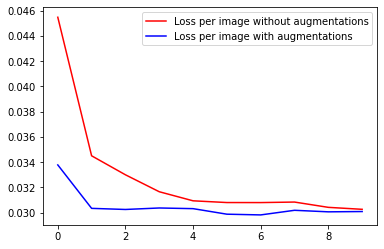

In [8]:
#Plots the loss for each training regimen, showing that using augmentations is better than training without.
fig, ax = plt.subplots()
ax.plot([x for x in range(len(losses[0]))], losses[0], c = 'RED', label = 'Loss per image without augmentations')
ax.plot([x for x in range(len(losses[0]))], losses[1], c = 'BLUE', label = 'Loss per image with augmentations')
ax.legend()
plt.show()